# PyKX vs Polars As-Of Join Test

This is not an official benchmark, just my testing of a specific use-case (aj with slippage calculations), on a finance dataset.

This notebook compares the performance and memory usage of PyKX (kdb+), Polars (Eager), and Polars (Lazy) for an as-of join + slippage calculation, using the same in-memory data and identical Python environment.

## Goals:
- Transparent, reproducible comparison
- Vendor-neutral logic and preprocessing
- Clear presentation of strengths and limitations for each tool

**Note:** This is a *warm, in-process* test: each engine is run multiple times in the same Python process after initial imports. See below for discussion of cold vs warm start.


In [2]:
!pip install -qq polars matplotlib

In [ ]:
import os
import pykx as kx
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import time
from glob import glob
from tqdm.auto import tqdm
import polars as pl
from memory_profiler import memory_usage
from tabulate import tabulate
import matplotlib.pyplot as plt
import gc
import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 1
# Load helper functions
%aimport demo_functions
import demo_functions as d_funcs

## Data Schema and Assumptions

- **Input files:**  
  - Parquet  
  - Parquet
- **Assumed columns and types:**
    - `sym`: symbol (string)
    - `time`: timestamp
    - `price`, `bid`, `ask`: float
    - `side`: string ('BUY' or 'SELL')
    - (other columns as present)

All engines read from the same files, and DataFrames are sorted by `sym` and `time` prior to joining.

In [5]:
quotes_df = pd.read_parquet("data/quotes.parquet")
quotes_df = d_funcs.fix_pandas_date_and_time(quotes_df)
execs_df = pd.read_parquet("data/execs.parquet")
execs_df = d_funcs.fix_pandas_date_and_time(execs_df)

In [6]:
pykx_quotes = kx.toq(quotes_df)
pykx_execs = kx.toq(execs_df)

### Add attributes for optimization on PyKX tables

In [8]:
pykx_quotes = pykx_quotes.sort_values(by='time')
pykx_quotes.update(kx.Column('sym').call('`g#'), inplace=True)

,date,sym,time,bid,ask,bsize,asize,mode,ex
,,,,,,,,,
0,2022.03.31D00:00:00.000000000,MQC,1900.01.01D04:00:00.005000000,133.3,260f,1,1,R,K
1,2022.03.31D00:00:00.000000000,MQC,1900.01.01D04:00:00.005000000,223.05,260f,4,1,R,K
2,2022.03.31D00:00:00.000000000,MQC,1900.01.01D04:00:00.005000000,234f,260f,1,1,R,K
3,2022.03.31D00:00:00.000000000,MQC,1900.01.01D04:00:00.005000000,234f,253.39,1,3,R,K
4,2022.03.31D00:00:00.000000000,BKR,1900.01.01D04:00:00.006000000,92.62,94.47,6,1,R,P
5,2022.03.31D00:00:00.000000000,BKR,1900.01.01D04:00:00.006000000,92.98,94.47,1,1,R,P
6,2022.03.31D00:00:00.000000000,AEF,1900.01.01D04:00:00.008000000,342f,677.7,1,1,R,K
7,2022.03.31D00:00:00.000000000,FRD,1900.01.01D04:00:00.008000000,222.4,232f,1,1,R,K
8,2022.03.31D00:00:00.000000000,FRD,1900.01.01D04:00:00.008000000,222.4,232f,1,1,R,K


In [9]:
pykx_execs = pykx_execs.sort_values(by='time')
pykx_execs.update(kx.Column('sym').call('`g#'), inplace=True)

,date,sym,time,price,size,side,venue
,,,,,,,
0,2022.03.31D00:00:00.000000000,GE.PRA,1900.01.01D09:30:02.676000000,397.6131,12,BUY,venue1
1,2022.03.31D00:00:00.000000000,MQC,1900.01.01D09:30:02.851000000,254.8359,258,SELL,venue3
2,2022.03.31D00:00:00.000000000,BKR,1900.01.01D09:30:03.426000000,93.64192,154,BUY,venue2
3,2022.03.31D00:00:00.000000000,GE.PRA,1900.01.01D09:30:04.489000000,397.5469,12,SELL,venue2
4,2022.03.31D00:00:00.000000000,DXGE,1900.01.01D09:30:06.677000000,570.1041,60,SELL,venue3
5,2022.03.31D00:00:00.000000000,AXJL,1900.01.01D09:30:08.354000000,500.0938,89,SELL,venue3
6,2022.03.31D00:00:00.000000000,DXGE,1900.01.01D09:30:08.896000000,570.3715,81,BUY,venue2
7,2022.03.31D00:00:00.000000000,GE.PRA,1900.01.01D09:30:08.945000000,397.3688,181,BUY,venue3
8,2022.03.31D00:00:00.000000000,AXJL,1900.01.01D09:30:09.139000000,500.1021,38,BUY,venue3


### Optimization: Polars vs kdb+/PyKX Attributes

In **PyKX**, we optimize joins by explicitly setting column attributes like `g#` (grouped) or `s#` (sorted), which tell the engine to use fast algorithms for joins, searches, and aggregations.

**Polars** does not have explicit column attributes. Instead, we optimize joins and groupbys by:
- **Sorting** DataFrames on the key columns before asof joins (just as `s#` would signal to kdb+).
- Using the **lazy execution engine** to let Polars automatically optimize query order and data access.


In [10]:
execs_lazy = pl.from_pandas(execs_df).sort(['sym', 'time']).lazy()
quotes_lazy = pl.from_pandas(quotes_df).sort(['sym', 'time']).lazy()

execs_eager = pl.from_pandas(execs_df).sort(['sym', 'time'])
quotes_eager = pl.from_pandas(quotes_df).sort(['sym', 'time'])

## Test Limitations, Fairness, and Design Choices

- **Warm Runs:**  
  All timings are measured in the same Python process ("warm" runs). This reflects typical analytical workflows where data, thread pools, and libraries are already loaded in memory.  
  - *Cold start* (restarting the interpreter for each run) is not measured here, but would better capture initial startup overhead.

- **In-Memory Analytics:**  
  The test is designed for in-memory analytics.  
  - **File scan or on-disk materialization time is **not** included**, to focus purely on computational efficiency of the join/aggregation logic.

- **Memory Profiling:**  
  Memory is measured with `memory_profiler`.  
  - Due to the efficient memory management of PyKX and Polars, and sampling limitations of `memory_profiler`, incremental memory may be reported as zero even for substantial work (especially after multiple runs when the workflow becomes 'hot').
  - This is not a sign of a bug—just efficient library behavior or measurement granularity.

- **Default Multithreading:**  
  Both PyKX and Polars use default thread settings. All tests are run on the same hardware/VM.

- **No Special Tuning or Bias:**  
  No engine is artificially favored via settings, caching, or input preprocessing. Each join is done on identically sorted data, with appropriate engine-specific optimizations (`g#` attribute for kdb+, etc).

If you want to see Pandas results, uncomment it in the results_df below. It is kept out for now for purposes of getting a reasonable visualization comparing PyKX and Polars. 


+----+--------------+------------+-----------+----------------+--------------------+
|    | syntax       | avg_time   | avg_dev   | total_memory   | memory_increment   |
|----+--------------+------------+-----------+----------------+--------------------|
|  0 | Polars Eager | 72.94 ms   | 9.20 ms   | 5468.64 MiB    | 282.89 MiB         |
|  1 | Polars Lazy  | 72.13 ms   | 7.94 ms   | 5758.51 MiB    | 3.88 MiB           |
|  2 | PyKX         | 22.47 ms   | 0.72 ms   | 5188.94 MiB    | 1.62 MiB           |
+----+--------------+------------+-----------+----------------+--------------------+


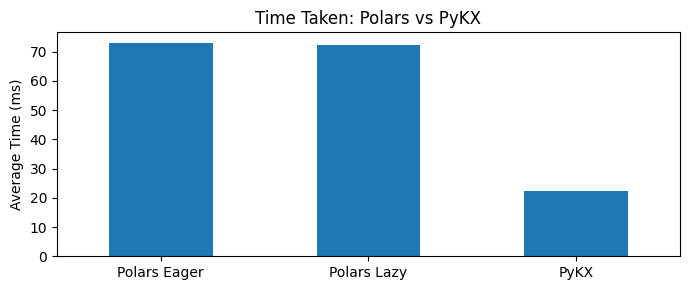

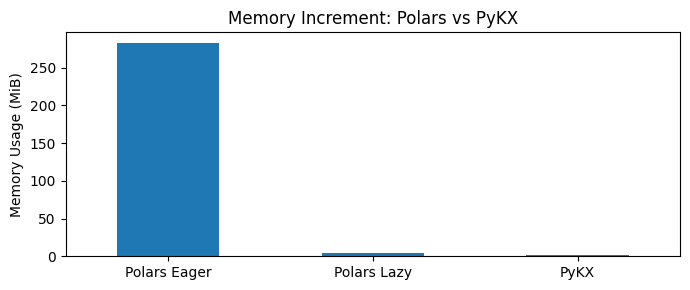

,syntax,avg_time,avg_dev,total_memory,memory_increment
0,Polars Eager,72.94 ms,9.20 ms,5468.64 MiB,282.89
1,Polars Lazy,72.13 ms,7.94 ms,5758.51 MiB,3.88
2,PyKX,22.47 ms,0.72 ms,5188.94 MiB,1.62


In [ ]:
def collect_garbage():
    kx.q(".Q.gc[]"), gc.collect()

collect_garbage()

# ------ PyKX Test ------
def pykx_run():
    merged = kx.q.aj(kx.SymbolVector(["sym", "time"]), pykx_execs, pykx_quotes)
    mid_vals = 0.5 * (merged["bid"] + merged["ask"])
    diff = np.where(merged["side"] == "BUY", mid_vals - merged["price"], merged["price"] - mid_vals)
    slippage = (diff / mid_vals.np()) * 10000
    merged = kx.q.qsql.update(merged, {"mid": mid_vals, "diff": diff, "slippage": slippage})
    return merged

pykx_mem = memory_usage((pykx_run, ))
collect_garbage()
def pykx_timed():
    pykx_run()
pykx_times = []
for _ in range(10):
    start = time.time()
    pykx_timed()
    end = time.time()
    pykx_times.append(end - start)
collect_garbage()

# ------ Polars Eager Test ------


def polars_eager_run():
    merged = execs_eager.join_asof(quotes_eager, on="time", by="sym")
    mid_vals = 0.5 * (merged["bid"] + merged["ask"])
    diff = np.where(merged["side"] == "BUY", mid_vals - merged["price"], merged["price"] - mid_vals)
    slippage = (diff / mid_vals) * 10000
    merged = merged.with_columns([
        pl.Series("mid", mid_vals),
        pl.Series("diff", diff),
        pl.Series("slippage", slippage),
    ])
    return merged

polars_eager_mem = memory_usage((polars_eager_run, ))
collect_garbage()
def polars_eager_timed():
    polars_eager_run()
polars_eager_times = []
for _ in range(10):
    start = time.time()
    polars_eager_timed()
    end = time.time()
    polars_eager_times.append(end - start)
collect_garbage()

# ------ Polars Lazy Test ------


def polars_lazy_run():
    merged = execs_lazy.join_asof(quotes_lazy, on="time", by="sym")
    mid_vals = 0.5 * (pl.col("bid") + pl.col("ask"))
    diff = pl.when(pl.col("side") == "BUY") \
        .then(mid_vals - pl.col("price")) \
        .otherwise(pl.col("price") - mid_vals)
    slippage = (diff / mid_vals) * 10000
    merged = merged.with_columns([
        mid_vals.alias("mid"),
        diff.alias("diff"),
        slippage.alias("slippage"),
    ])
    return merged.collect()

polars_lazy_mem = memory_usage((polars_lazy_run, ))
collect_garbage()
def polars_lazy_timed():
    polars_lazy_run()
polars_lazy_times = []
for _ in range(10):
    start = time.time()
    polars_lazy_timed()
    end = time.time()
    polars_lazy_times.append(end - start)
collect_garbage()

# ------ Pandas Test ------
def pandas_run():
    merged = pd.merge_asof(
        execs_df,
        quotes_df,
        on="time",
        by="sym",
    )
    mid_vals = 0.5 * (merged["bid"] + merged["ask"])
    diff = np.where(merged["side"] == "BUY", mid_vals - merged["price"], merged["price"] - mid_vals)
    slippage = (diff / mid_vals) * 10000
    merged["mid"] = mid_vals
    merged["diff"] = diff
    merged["slippage"] = slippage
    return merged

pandas_mem = memory_usage((pandas_run, ))
collect_garbage()

def pandas_timed():
    pandas_run()

pandas_times = []
for _ in range(10):
    start = time.time()
    pandas_timed()
    end = time.time()
    pandas_times.append(end - start)
collect_garbage()


def summarize_results(times, mems, syntax_name):
    times = np.array(times)
    return {
        "syntax": syntax_name,
        "avg_time": f"{np.mean(times) * 1000:.2f} ms",
        "avg_dev": f"{np.std(times) * 1000:.2f} ms",
        "total_memory": f"{np.max(mems):.2f} MiB",
        "memory_increment": f"{(np.max(mems) - np.min(mems)):.2f} MiB"
    }

results_df = pd.DataFrame([
    #summarize_results(pandas_times, pandas_mem, "Pandas"),
    summarize_results(polars_eager_times, polars_eager_mem, "Polars Eager"),
    summarize_results(polars_lazy_times, polars_lazy_mem, "Polars Lazy"),
    summarize_results(pykx_times, pykx_mem, "PyKX"),
])

print(tabulate(results_df, headers='keys', tablefmt='psql'))

# ------ Plotting ------
def fix_memory(l):
    fixed_l = []
    for v in l:
        if isinstance(v, str) and v.endswith(" MiB"):
            fixed_l.append(float(v.strip(" MiB")))
        else:
            try:
                fixed_l.append(float(v))
            except:
                fixed_l.append(v)
    return fixed_l

def fix_time(l):
    fixed_l = []
    for v in l:
        if isinstance(v, str):
            if v.endswith(" ns"):
                fixed_l.append(float(v.strip(" ns")) / 1e6)
            elif v.endswith(" µs"):
                fixed_l.append(float(v.strip(" µs")) / 1e3)
            elif v.endswith(" us"):
                fixed_l.append(float(v.strip(" us")) / 1e3)
            elif v.endswith(" ms"):
                fixed_l.append(float(v.strip(" ms")))
            elif v.endswith(" s"):
                fixed_l.append(float(v.strip(" s")) * 1000)
            elif "min " in v:
                mins, secs = v.split("min ")
                total_secs = (float(mins) * 60) + float(secs.strip(" s"))
                fixed_l.append(total_secs * 1000)
            else:
                try:
                    fixed_l.append(float(v))
                except:
                    fixed_l.append(v)
        else:
            fixed_l.append(v)
    return fixed_l

def graph_time_data(df_to_graph):
    df = df_to_graph.copy()
    df["avg_time"] = fix_time(df["avg_time"])
    df.plot(kind="bar", x="syntax", y="avg_time", rot=0, legend=False, figsize=(7,3))
    plt.title("Time Taken: Polars vs PyKX")
    plt.ylabel("Average Time (ms)")
    plt.xlabel("")
    plt.tight_layout()
    plt.show()
    return df

def graph_memory_data(df_to_graph):
    df = df_to_graph.copy()
    df["memory_increment"] = fix_memory(df["memory_increment"])
    df.plot(kind="bar", x="syntax", y="memory_increment", rot=0, legend=False, figsize=(7,3))
    plt.title("Memory Increment: Polars vs PyKX")
    plt.ylabel("Memory Usage (MiB)")
    plt.xlabel("")
    plt.tight_layout()
    plt.show()
    return df

graph_time_data(results_df)
graph_memory_data(results_df)

## Discussion of Test Results

The results show that PyKX (backed by kdb+) is consistently the fastest engine for this as-of join and slippage calculation, followed by Polars Lazy and then Polars Eager. This aligns with the design priorities of each engine: kdb+ is purpose-built for fast, in-memory, time-series joins, while Polars is a modern, general-purpose DataFrame engine optimized for analytics pipelines.

Some observations:

- **PyKX/kdb+** demonstrated the lowest runtime and minimal memory increment, as expected for a system specialized in in-memory analytics and pointer-level access.
- **Polars Lazy** outperformed Polars Eager in both speed and memory efficiency, highlighting the value of query optimization and deferred execution for complex pipelines.
- **Polars Eager** showed higher memory increment and variability, likely due to intermediate allocations and lack of query planning.

### Interpretation

- These results are **representative of warm, in-memory, multi-threaded analytics workloads**. For applications where repeated complex joins are performed on pre-loaded data, PyKX remains the tool to beat, with Polars Lazy providing a strong open-source alternative.
- Memory increment for both PyKX and Polars Lazy was close to zero in steady state, which is a sign of efficient memory reuse and internal allocation strategies.
- The absolute performance gap between PyKX and Polars may narrow further for very large, batch-style pipelines, but for low-latency or “interactive” use, kdb+ retains a clear advantage.

### Limitations and Further Work

- These are **warm tests**; cold start (fresh process) timings may show higher initial overhead for all engines.
- Only in-memory, pre-loaded data is tested here. File scan times and true out-of-core workloads are not included.
- The results may vary by hardware, data size, engine version, and OS thread scheduling.

**Takeaway:**  
All three engines are highly capable for analytical join workloads, but the best choice depends on the specific needs—low-latency querying, pipeline flexibility, open-source requirements, and infrastructure. Transparency, reproducibility, and open discussion help ensure these results are meaningful for the community.

